#Import Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
from torch.autograd import Variable  
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import quantile_transform
from tqdm import tqdm_notebook as tqdm
from torch.utils.data import Dataset,DataLoader
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"{device}" " is available.")

cuda is available.


#Data Exploration

In [175]:
Ny_Home_Df = pd.read_csv('Sensors.csv')
Ny_Home_Df.drop(Ny_Home_Df.tail(1).index,inplace=True) #remove the last row
Ny_Home_Df.columns = [col.replace(' [kW]', '') for col in Ny_Home_Df.columns]
Ny_Home_Df['All_Furnace'] = Ny_Home_Df[['Furnace 1','Furnace 2']].sum(axis=1)
Ny_Home_Df['All_Kitchen'] = Ny_Home_Df[['Kitchen 12','Kitchen 14','Kitchen 38','Fridge','Dishwasher','Microwave']].sum(axis=1)
Ny_Home_Df = Ny_Home_Df.drop(['icon', 'summary','gen','cloudCover','time','pressure', 'Furnace 1', 'Furnace 2'], axis=1)
time_index = pd.date_range('2016-01-01 05:00', periods=len(Ny_Home_Df), freq='min')  
time_index = pd.DatetimeIndex(time_index)
Ny_Home_Df = Ny_Home_Df.set_index(time_index)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (0,27) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [176]:
features = ['temperature','humidity', 'visibility','apparentTemperature','windSpeed', 'windBearing', 'precipIntensity','dewPoint','precipProbability']
# targets = ['use','Dishwasher','Home office','Fridge','Wine cellar','Garage door','Barn','Well','Microwave','Living room','Solar', 'All_Furnace' ,'All_Kitchen']
targets = ['use','Dishwasher','Home office','Fridge','Wine cellar','Garage door','Barn','Well','Microwave','Living room','Solar', 'All_Furnace' ,'All_Kitchen']
df = Ny_Home_Df[targets].resample('H').sum()
df1 = Ny_Home_Df[features].resample('H').mean()
df_hr = pd.concat([df, df1], axis=1)
df_hr.head()

,use,Dishwasher,Home office,Fridge,Wine cellar,Garage door,Barn,Well,Microwave,Living room,Solar,All_Furnace,All_Kitchen,temperature,humidity,visibility,apparentTemperature,windSpeed,windBearing,precipIntensity,dewPoint,precipProbability
2016-01-01 05:00:00,62.647783,0.003817,14.508850,2.271667,3.801033,0.782767,2.332833,0.062533,1.299100,0.090283,0.198417,23.591283,3.623818,36.131000,0.619667,10.0,29.264667,9.150333,282.100000,0.0,24.383333,0.0
2016-01-01 06:00:00,55.090017,0.005950,2.597617,4.531317,6.776500,0.770167,2.350883,0.061250,0.252967,0.097083,0.205300,27.402450,4.835151,35.838667,0.610000,10.0,29.364667,8.284000,284.733333,0.0,23.866000,0.0
2016-01-01 07:00:00,42.884167,0.002550,2.604967,3.569133,0.431050,0.797917,2.066350,0.060833,0.254733,0.097717,0.206900,22.330200,3.870001,35.385000,0.613000,10.0,29.034000,7.927000,279.400000,0.0,23.469000,0.0
2016-01-01 08:00:00,57.600767,0.008300,3.900833,3.624717,0.422683,0.775517,2.051700,0.060983,0.256450,0.098067,0.206850,36.982217,3.937801,35.282000,0.640000,10.0,30.395333,5.684667,265.000000,0.0,24.202667,0.0
2016-01-01 09:00:00,38.390183,0.003617,2.603500,2.106350,0.428567,0.793200,1.909783,0.060817,0.255467,0.099000,0.206350,20.630550,2.413185,35.451667,0.641667,10.0,29.673333,6.975000,265.500000,0.0,24.423333,0.0


In [177]:
df_hr.describe()

,use,Dishwasher,Home office,Fridge,Wine cellar,Garage door,Barn,Well,Microwave,Living room,Solar,All_Furnace,All_Kitchen,temperature,humidity,visibility,apparentTemperature,windSpeed,windBearing,precipIntensity,dewPoint,precipProbability
count,8399.000000,8399.000000,8399.000000,8399.000000,8399.000000,8399.000000,8399.000000,8399.000000,8399.000000,8399.000000,8399.000000,8399.000000,8399.000000,8399.000000,8399.000000,8399.000000,8399.000000,8399.000000,8399.000000,8399.000000,8399.000000,8399.000000
mean,51.534676,1.881939,4.876923,3.813158,2.528048,0.848297,3.511565,0.938465,0.658940,2.118642,4.573493,14.158526,6.941272,50.741005,0.664097,9.253414,48.262262,6.649940,202.355870,0.002599,38.693571,0.056480
std,48.398038,7.136702,5.619182,2.622486,2.840209,0.359387,6.370624,2.062920,2.159726,4.902443,7.428225,12.201422,8.446124,19.096105,0.193418,1.589102,22.004686,3.922501,100.930971,0.010823,19.082478,0.161169
min,0.048000,0.000000,0.004998,0.006000,0.001002,0.003000,0.004998,0.000000,0.000000,0.000000,0.013000,0.018002,0.006000,-12.589000,0.130000,0.283333,-31.354667,0.168000,0.000000,0.000000,-27.170333,0.000000
25%,25.775450,0.000418,2.436692,2.132825,0.439200,0.767083,1.810617,0.059450,0.233142,0.090783,0.201983,5.216475,2.714035,35.784000,0.514917,9.406333,31.056667,3.670167,152.958333,0.000000,24.535083,0.000000
50%,40.558717,0.002667,2.550317,3.380300,0.866033,0.778117,1.929733,0.060367,0.239983,0.097983,0.258433,7.501433,4.189485,50.341000,0.681333,9.997833,50.111667,5.900000,207.083333,0.000000,38.970667,0.000000
75%,61.007775,0.010292,4.536300,4.894092,4.509825,0.789875,2.193458,0.065958,0.246442,0.116583,5.484800,20.746417,7.170001,66.300917,0.835333,10.000000,66.300917,8.888500,290.591667,0.000000,54.801583,0.000000
max,574.811067,49.475367,39.994233,23.459183,46.992567,17.666050,108.786283,31.924767,40.893600,21.482917,32.710450,70.653717,75.499868,93.503667,0.980000,10.000000,100.930667,22.674000,358.833333,0.179407,75.425333,0.838667


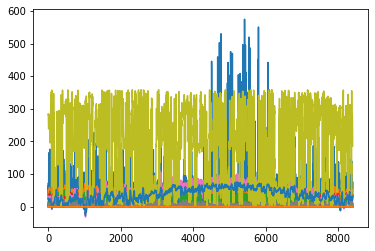

In [178]:
training_set = df_hr.iloc[:,:].values
plt.plot(training_set)
plt.show()

#Data Preprocessing

In [179]:
def sliding_windows(data, seq_length):
    x = []
    y = []

    for i in range(len(data)-seq_length-1):
        _x = data[i:(i+seq_length)]
        _y = data[i+seq_length]
        x.append(_x)
        y.append(_y)

    return np.array(x),np.array(y)

sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 24
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.67)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x))).to(device)
dataY = Variable(torch.Tensor(np.array(y))).to(device)

trainX = Variable(torch.Tensor(np.array(x[0:train_size]))).to(device)
trainY = Variable(torch.Tensor(np.array(y[0:train_size]))).to(device)

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)]))).to(device)
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)]))).to(device)

In [7]:
testX.shape

torch.Size([2764, 24, 24])

#Models

In [199]:
class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)
        
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size)).cuda()
        
        c_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size)).cuda()
        
        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))
        
        h_out = h_out.view(-1, self.hidden_size)
        
        out = self.fc(h_out)
        
        out = torch.clip(out, 0)
        return out

#Training

In [200]:
num_epochs = 5000
learning_rate = 0.001

input_size = 22
hidden_size = 15
num_layers = 1

num_classes = 22

lstm = LSTM(num_classes, input_size, hidden_size, num_layers)
lstm = lstm.to(device)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
loss_ = []
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    # obtain the loss function
    loss = criterion(outputs, trainY)
    loss.backward()
    loss_.append(loss)
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

Epoch: 0, loss: 0.12251
Epoch: 100, loss: 0.02672
Epoch: 200, loss: 0.02344
Epoch: 300, loss: 0.01978
Epoch: 400, loss: 0.01788
Epoch: 500, loss: 0.01679
Epoch: 600, loss: 0.01606
Epoch: 700, loss: 0.01547
Epoch: 800, loss: 0.01495
Epoch: 900, loss: 0.01452
Epoch: 1000, loss: 0.01419
Epoch: 1100, loss: 0.01394
Epoch: 1200, loss: 0.01375
Epoch: 1300, loss: 0.01360
Epoch: 1400, loss: 0.01347
Epoch: 1500, loss: 0.01336
Epoch: 1600, loss: 0.01327
Epoch: 1700, loss: 0.01318
Epoch: 1800, loss: 0.01309
Epoch: 1900, loss: 0.01301
Epoch: 2000, loss: 0.01294
Epoch: 2100, loss: 0.01288
Epoch: 2200, loss: 0.01283
Epoch: 2300, loss: 0.01279
Epoch: 2400, loss: 0.01275
Epoch: 2500, loss: 0.01271
Epoch: 2600, loss: 0.01268
Epoch: 2700, loss: 0.01264
Epoch: 2800, loss: 0.01261
Epoch: 2900, loss: 0.01259
Epoch: 3000, loss: 0.01256
Epoch: 3100, loss: 0.01253
Epoch: 3200, loss: 0.01251
Epoch: 3300, loss: 0.01248
Epoch: 3400, loss: 0.01246
Epoch: 3500, loss: 0.01243
Epoch: 3600, loss: 0.01241
Epoch: 3700, 

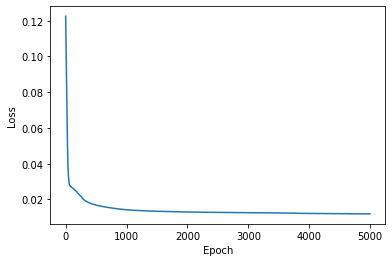

In [201]:
plt.plot(loss_)
plt.xlabel('Epoch')
plt.ylabel('Loss')
# Save the trained model
PATH = './lstm_withWeather.pth'
torch.save(lstm.state_dict(), PATH)

#Testing

Load the pre-trained model

In [202]:
input_size = 22
hidden_size = 15
num_layers = 1

num_classes = 22

lstm = LSTM(num_classes, input_size, hidden_size, num_layers)
PATH_lstm = './lstm_withWeather.pth'
lstm.load_state_dict(torch.load(PATH_lstm))
lstm = lstm.to(device)

Generate a Excel file that includes predicted power

In [203]:
Y_predicted = lstm(dataX)
Y_predicted = Y_predicted.data.cpu().detach().numpy()
Y_predicted = sc.inverse_transform(Y_predicted)
Y_actual = sc.inverse_transform(dataY.cpu().detach().numpy())

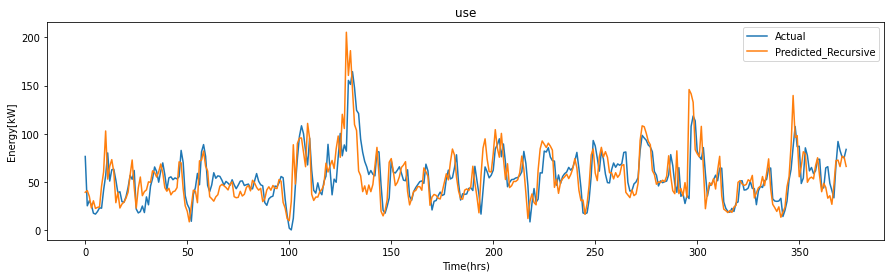

In [223]:
feature = 0
f = plt.figure(figsize=(15,4))
plt.plot(Y_predicted[8000:8500,feature])
plt.plot(Y_actual[8000:8500,feature])
plt.title(df_hr.columns[feature])
plt.xlabel('Time(hrs)')
plt.ylabel('Energy[kW]')
plt.legend(['Actual','Predicted_Recursive','Predicted_onetime'])
plt.show()

In [206]:
target_col = ['use_pred','Dishwasher_pred','Home office_pred','Fridge_pred','Wine cellar_pred','Garage door_pred','Barn_pred','Well_pred','Microwave_pred','Living room_pred','Solar_pred', 'All_Furnace_pred' ,'All_Kitchen_pred']
df_pred = pd.DataFrame(Y_predicted[:,:13],columns=target_col,index=df.tail(Y_predicted.shape[0]).index)

In [224]:
new_df = pd.concat([df_hr, df_pred], axis=1)

In [225]:
new_df.to_csv('New_df.csv')

Recursive multi-step forecast

In [153]:
# make a recursive multi-step forecast
def forecast(model, input_x, n_input, pred_steps):
    yhat_sequence = torch.empty(0,input_x.shape[-1]).to(device)
    input_data = input_x
    for j in range(pred_steps):
      # prepare the input data
      X = input_data[:,-n_input:,:]
      # make a one-step forecast
      yhat = model(X)
      # add to the result
      yhat_sequence = torch.cat((yhat_sequence,yhat), 0)
      # add the prediction to the input
      input_data = torch.cat((input_data,yhat.reshape(1,yhat.shape[0],yhat.shape[1])), 1)
    return yhat_sequence

n_input = 48 #look at last 24 hrs
pred_steps = 24 #predict the next # hrs reccursively 

# predict the week, recursively
yhat_sequence = forecast(lstm, testX[0,:,:].reshape(1,testX.shape[1],testX.shape[2]), n_input, pred_steps)

yhat_sequence = yhat_sequence.data.cpu().detach().numpy()
data_predict = sc.inverse_transform(yhat_sequence)
data_actual = sc.inverse_transform(testY.cpu().detach().numpy())

Actual forecast 

In [154]:
yhat_onetime_pred = lstm(testX[0:pred_steps,:,:])
yhat_onetime_pred = yhat_onetime_pred.data.cpu().detach().numpy()
data_predict_onetime = sc.inverse_transform(yhat_onetime_pred)

Forecast hourly error

In [155]:
from sklearn.metrics import mean_squared_error
# evaluate one or more hrs forecasts against expected values
# make a recursive multi-step forecast
def evaluate_forecasts(actual, predicted):
    scores = []
    for i in range(actual.shape[0]):
      # calculate an RMSE score for each hour
      mse = mean_squared_error(actual[i, :], predicted[i, :])
      rmse = np.sqrt(mse)
      scores.append(rmse)
    return scores

scores = evaluate_forecasts(data_actual[0:pred_steps,:],data_predict)

Text(0, 0.5, 'Error')

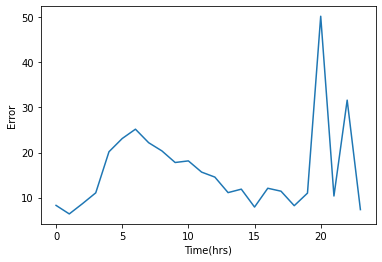

In [156]:
plt.plot(scores)
plt.xlabel('Time(hrs)')
plt.ylabel('Error')

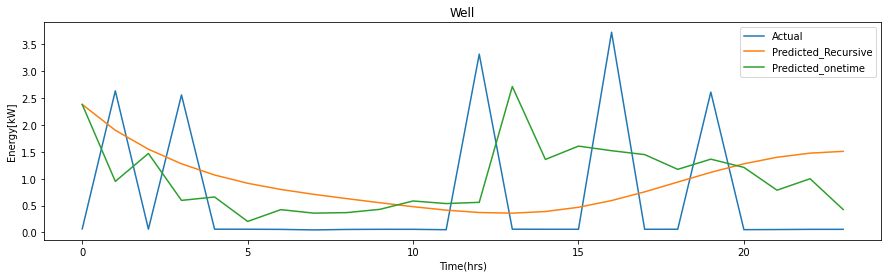

In [163]:
feature = 7
f = plt.figure(figsize=(15,4))
plt.plot(data_actual[0:pred_steps,feature])
plt.plot(data_predict[:,feature])
plt.plot(data_predict_onetime[:,feature])
plt.title(df_hr.columns[feature])
plt.xlabel('Time(hrs)')
plt.ylabel('Energy[kW]')
plt.legend(['Actual','Predicted_Recursive','Predicted_onetime'])
plt.show()